# **Initial Models**

**Author**: Grace Samuel  
**Project**: Biopharma Funding Analysis  
**Notebook Purpose**: To build, evaluate, and compare initial supervised learning models for predicting biopharma funding amounts using log-transformed targets. This notebook includes performance evaluation, residual analysis, and cross-validation to identify the best baseline models for future tuning and interpretation.

## 1. Load Libraries

In [25]:
# Core libraries
import pandas as pd
import numpy as np

# Modeling: Linear, Tree-based, Neural Network
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cross-validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab utilities (for uploading files)
from google.colab import files

# Display settings
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set(style="whitegrid")


## 2. Load Dataset

In [26]:
# Upload the CSV file from local machine (for Google Colab use)
uploaded = files.upload()

# Load uploaded CSVs into pandas
X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train_log.csv').squeeze()
y_test = pd.read_csv('y_test_log.csv').squeeze()

# Confirm shapes
print("Training features:", X_train.shape)
print("Test features:", X_test.shape)
print("Training target:", y_train.shape)
print("Test target:", y_test.shape)

Saving X_test_final.csv to X_test_final (1).csv
Saving X_train_final.csv to X_train_final (1).csv
Saving y_test_log.csv to y_test_log (1).csv
Saving y_train_log.csv to y_train_log (1).csv
Training features: (6348, 10)
Test features: (2741, 10)
Training target: (6348,)
Test target: (2741,)


## 3. Baseline Linear Regression Model

In [27]:
# Initialize and fit model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance (log-transformed target)
mae_log = mean_absolute_error(y_test, y_pred_lr)
mse_log = mean_squared_error(y_test, y_pred_lr)
r2_log = r2_score(y_test, y_pred_lr)

print("Linear Regression Results (log-transformed target):")
print(f"MAE: {mae_log:.3f}")
print(f"MSE: {mse_log:.3f}")
print(f"R²:  {r2_log:.3f}")

# Inverse transform predictions for dollar-scale evaluation
y_pred_dollars = np.expm1(y_pred_lr)
y_test_dollars = np.expm1(y_test)

# Evaluate performance (original $ scale)
mae_dollars = mean_absolute_error(y_test_dollars, y_pred_dollars)
mse_dollars = mean_squared_error(y_test_dollars, y_pred_dollars)
r2_dollars = r2_score(y_test_dollars, y_pred_dollars)

print("\nLinear Regression Results (original $ scale):")
print(f"MAE: ${mae_dollars:,.0f}")
print(f"MSE: ${mse_dollars:,.0f}")
print(f"R²:  {r2_dollars:.3f}")



Linear Regression Results (log-transformed target):
MAE: 1.088
MSE: 1.711
R²:  0.080

Linear Regression Results (original $ scale):
MAE: $55
MSE: $13,015
R²:  -0.085


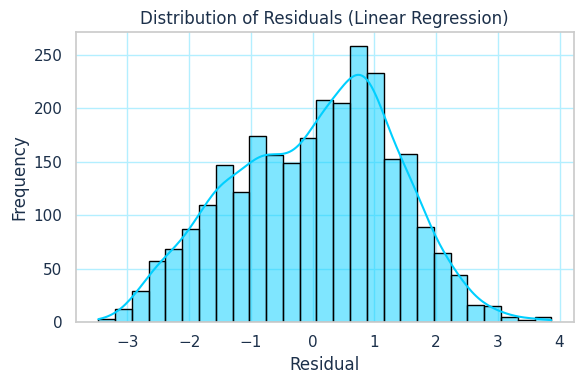

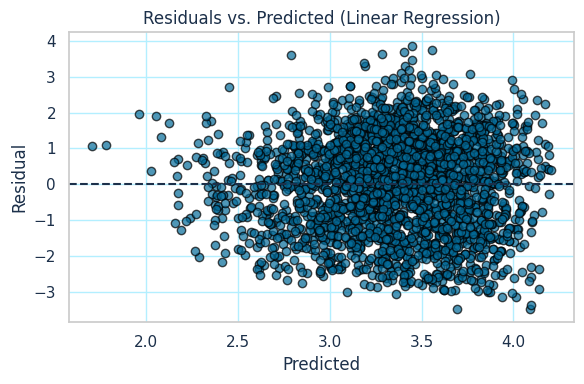

In [28]:
# Set accessible color palette
palette = {
    "white": "#FFFFFF",
    "light": "#B3EFFF",
    "bright": "#00CFFF",
    "medium": "#046B99",
    "dark": "#1C304A",
    "black": "#000000"
}

# Compute residuals
residuals = y_test - y_pred_lr

# Plot 1: Distribution of residuals
plt.figure(figsize=(6, 4), facecolor=palette["white"])
sns.histplot(residuals, kde=True, color=palette["bright"], edgecolor=palette["black"])
plt.title("Distribution of Residuals (Linear Regression)", color=palette["dark"])
plt.xlabel("Residual", color=palette["dark"])
plt.ylabel("Frequency", color=palette["dark"])
plt.grid(True, color=palette["light"])
plt.tick_params(colors=palette["dark"])
plt.tight_layout()
plt.show()

# Plot 2: Residuals vs. predicted values
plt.figure(figsize=(6, 4), facecolor=palette["white"])
plt.scatter(y_pred_lr, residuals, color=palette["medium"], alpha=0.7, edgecolor=palette["black"])
plt.axhline(0, color=palette["dark"], linestyle='--')
plt.title("Residuals vs. Predicted (Linear Regression)", color=palette["dark"])
plt.xlabel("Predicted", color=palette["dark"])
plt.ylabel("Residual", color=palette["dark"])
plt.grid(True, color=palette["light"])
plt.tick_params(colors=palette["dark"])
plt.tight_layout()
plt.show()


## 4. Random Forest Regressor

In [30]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance (log-transformed target)
mae_rf_log = mean_absolute_error(y_test, y_pred_rf)
mse_rf_log = mean_squared_error(y_test, y_pred_rf)
r2_rf_log = r2_score(y_test, y_pred_rf)

# Convert predictions to original dollar scale
y_pred_rf_dollars = np.expm1(y_pred_rf)
y_test_dollars = np.expm1(y_test)

# Evaluate performance (original $ scale)
mae_rf_dollars = mean_absolute_error(y_test_dollars, y_pred_rf_dollars)
mse_rf_dollars = mean_squared_error(y_test_dollars, y_pred_rf_dollars)
r2_rf_dollars = r2_score(y_test_dollars, y_pred_rf_dollars)

# Print results together
print("Random Forest Results (log-transformed target):")
print(f"MAE: {mae_rf_log:.3f}")
print(f"MSE: {mse_rf_log:.3f}")
print(f"R²:  {r2_rf_log:.3f}")

print("\nRandom Forest Results (original $ scale):")
print(f"MAE: ${mae_rf_dollars:,.0f}")
print(f"MSE: ${mse_rf_dollars:,.0f}")
print(f"R²:  {r2_rf_dollars:.3f}")



Random Forest Results (log-transformed target):
MAE: 0.818
MSE: 1.091
R²:  0.414

Random Forest Results (original $ scale):
MAE: $45
MSE: $9,499
R²:  0.208


In [31]:
# Cross-validation (5-fold)
cv_scores_rf = cross_val_score(
    RandomForestRegressor(random_state=42),
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("\nRandom Forest Cross-Validated R² Scores:", cv_scores_rf)
print(f"Mean R²: {cv_scores_rf.mean():.3f}")



Random Forest Cross-Validated R² Scores: [0.4198263  0.35417616 0.40106823 0.41027291 0.41330152]
Mean R²: 0.400


## 5. XGBoost

In [32]:
# Initialize and train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance (log-transformed target)
mae_xgb_log = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb_log = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_log = r2_score(y_test, y_pred_xgb)

# Convert predictions to original dollar scale
y_pred_xgb_dollars = np.expm1(y_pred_xgb)
y_test_dollars = np.expm1(y_test)

# Evaluate performance (original $ scale)
mae_xgb_dollars = mean_absolute_error(y_test_dollars, y_pred_xgb_dollars)
mse_xgb_dollars = mean_squared_error(y_test_dollars, y_pred_xgb_dollars)
r2_xgb_dollars = r2_score(y_test_dollars, y_pred_xgb_dollars)

# Print results together
print("XGBoost Results (log-transformed target):")
print(f"MAE: {mae_xgb_log:.3f}")
print(f"MSE: {mse_xgb_log:.3f}")
print(f"R²:  {r2_xgb_log:.3f}")

print("\nXGBoost Results (original $ scale):")
print(f"MAE: ${mae_xgb_dollars:,.0f}")
print(f"MSE: ${mse_xgb_dollars:,.0f}")
print(f"R²:  {r2_xgb_dollars:.3f}")


XGBoost Results (log-transformed target):
MAE: 0.882
MSE: 1.218
R²:  0.345

XGBoost Results (original $ scale):
MAE: $48
MSE: $11,186
R²:  0.067


In [33]:
# Cross-validation (5-fold)
xgb_cv_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_cv_scores = cross_val_score(xgb_cv_model, X_train, y_train, cv=5, scoring='r2')

print("\nXGBoost Cross-Validated R² Scores:", xgb_cv_scores)
print(f"Mean R²: {xgb_cv_scores.mean():.3f}")



XGBoost Cross-Validated R² Scores: [0.3643385  0.32637047 0.36293283 0.37658175 0.36498736]
Mean R²: 0.359


## 6. HistGradientBoosting Regressor

In [34]:
# Initialize and train the model
hgb_model = HistGradientBoostingRegressor(
    max_iter=100,
    learning_rate=0.1,
    max_depth=None,
    random_state=42
)
hgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_hgb = hgb_model.predict(X_test)

# Evaluate performance (log-transformed target)
mae_hgb_log = mean_absolute_error(y_test, y_pred_hgb)
mse_hgb_log = mean_squared_error(y_test, y_pred_hgb)
r2_hgb_log = r2_score(y_test, y_pred_hgb)

# Convert predictions to original dollar scale
y_pred_hgb_dollars = np.expm1(y_pred_hgb)
y_test_dollars = np.expm1(y_test)

# Evaluate performance (original $ scale)
mae_hgb_dollars = mean_absolute_error(y_test_dollars, y_pred_hgb_dollars)
mse_hgb_dollars = mean_squared_error(y_test_dollars, y_pred_hgb_dollars)
r2_hgb_dollars = r2_score(y_test_dollars, y_pred_hgb_dollars)

# Print results together
print("HistGradientBoosting Results (log-transformed target):")
print(f"MAE: {mae_hgb_log:.3f}")
print(f"MSE: {mse_hgb_log:.3f}")
print(f"R²:  {r2_hgb_log:.3f}")

print("\nHistGradientBoosting Results (original $ scale):")
print(f"MAE: ${mae_hgb_dollars:,.0f}")
print(f"MSE: ${mse_hgb_dollars:,.0f}")
print(f"R²:  {r2_hgb_dollars:.3f}")


HistGradientBoosting Results (log-transformed target):
MAE: 0.817
MSE: 1.076
R²:  0.421

HistGradientBoosting Results (original $ scale):
MAE: $45
MSE: $9,800
R²:  0.183


In [35]:
# Cross-validation (5-fold)
hgb_cv_model = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, random_state=42)
hgb_cv_scores = cross_val_score(hgb_cv_model, X_train, y_train, cv=5, scoring='r2')

print("\nHistGradientBoosting Cross-Validated R² Scores:", hgb_cv_scores)
print(f"Mean R²: {hgb_cv_scores.mean():.3f}")



HistGradientBoosting Cross-Validated R² Scores: [0.44733517 0.40155812 0.4713828  0.4645291  0.4469252 ]
Mean R²: 0.446


## 7. Neural Network Regressor (MLP)

In [36]:
# Initialize and train the model
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train, y_train)

# Predict on test set
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate performance (log-transformed target)
mae_mlp_log = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp_log = mean_squared_error(y_test, y_pred_mlp)
r2_mlp_log = r2_score(y_test, y_pred_mlp)

# Convert predictions to original dollar scale
y_pred_mlp_dollars = np.expm1(y_pred_mlp)
y_test_dollars = np.expm1(y_test)

# Evaluate performance (original $ scale)
mae_mlp_dollars = mean_absolute_error(y_test_dollars, y_pred_mlp_dollars)
mse_mlp_dollars = mean_squared_error(y_test_dollars, y_pred_mlp_dollars)
r2_mlp_dollars = r2_score(y_test_dollars, y_pred_mlp_dollars)

# Print results together
print("Neural Network (MLP) Results (log-transformed target):")
print(f"MAE: {mae_mlp_log:.3f}")
print(f"MSE: {mse_mlp_log:.3f}")
print(f"R²:  {r2_mlp_log:.3f}")

print("\nNeural Network (MLP) Results (original $ scale):")
print(f"MAE: ${mae_mlp_dollars:,.0f}")
print(f"MSE: ${mse_mlp_dollars:,.0f}")
print(f"R²:  {r2_mlp_dollars:.3f}")


Neural Network (MLP) Results (log-transformed target):
MAE: 1.048
MSE: 1.740
R²:  0.065

Neural Network (MLP) Results (original $ scale):
MAE: $54
MSE: $11,243
R²:  0.063


In [37]:
# Cross-validation (5-fold)
mlp_cv_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_cv_scores = cross_val_score(mlp_cv_model, X_train, y_train, cv=5, scoring='r2')

print("\nNeural Network (MLP) Cross-Validated R² Scores:", mlp_cv_scores)
print(f"Mean R²: {mlp_cv_scores.mean():.3f}")



Neural Network (MLP) Cross-Validated R² Scores: [ 0.09599714  0.04246311  0.08004083  0.04892507 -0.00385412]
Mean R²: 0.053


## 8. Summary and Next Steps


**Summary:**

- Trained five supervised models: Linear Regression, Random Forest, XGBoost,

- HistGradientBoosting, and a Neural Network (MLP).

- Evaluated model performance on both log-transformed and dollar-scale target variables.

- Performed 5-fold cross-validation to assess generalization and overfitting.

- HistGradientBoosting and Random Forest were the top-performing models.

- Linear Regression and MLP underperformed, likely due to underfitting and data limitations.

**Next steps:**

- Tune hyperparameters for HistGradientBoosting and Random Forest using GridSearchCV.

- Evaluate and visualize feature importance to improve model interpretability.

- Explore stacking or ensemble strategies if tuning does not yield meaningful improvements.

## 9. Code Validation Note

Code has been tested and runs without error in both Google Colab and local environments. All transformations have been validated at key checkpoints with print statements and visualizations.